# TF-IDF and SVM classification

In [1]:
# preprocessing & utilities
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# text handling 
import nltk
import re
import spacy
import string
from nltk.corpus import stopwords

# models for classification
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split


In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords, wordnet
from nltk import word_tokenize, pos_tag
from nltk.stem.wordnet import WordNetLemmatizer


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Erica\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Erica\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Erica\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Erica\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Functions

In [3]:
def plot_cm(pipeline, X_test, y_test):
    plot = plt.figure(figsize=(15,15))
    plot_confusion_matrix(pipeline, X_test, y_test, cmap="Blues")  
    plt.xticks(rotation=45, fontsize = 8)
    plt.yticks(rotation=0, fontsize = 8)
    
    plt.title("Confusion matrix")
    plt.show()
    return plot 
    
def eval_accuracy (pred, test):
    correct = 0
    for prediction,true_label in zip(predictions, y_test):
        if prediction==true_label:
            correct += 1
    return (correct/len(predictions))

In [4]:
df = pd.read_csv("data/books_def.csv", index_col=0)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36638 entries, Suzanne Collins to Mimi Baird|Eve Claxton
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   book_desc    36638 non-null  object 
 1   book_rating  36638 non-null  float64
 2   book_title   36638 non-null  object 
 3   genres       36638 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.4+ MB


In [6]:
df.head()

,book_desc,book_rating,book_title,genres
book_authors,,,,
Suzanne Collins,Winning will make you famous. Losing means cer...,4.33,The Hunger Games,Young Adult
J.K. Rowling|Mary GrandPré,There is a door at the end of a silent corrido...,4.48,Harry Potter and the Order of the Phoenix,Fantasy
Harper Lee,The unforgettable novel of a childhood in a sl...,4.27,To Kill a Mockingbird,Classics
Stephenie Meyer,About three things I was absolutely positive.F...,3.58,Twilight,Young Adult
Markus Zusak,Trying to make sense of the horrors of World W...,4.36,The Book Thief,Historical


In [7]:
df = df.reset_index()

In [8]:
fic_nonfic = ['Fiction', 'Nonfiction']
df_binary = df.loc[df['genres'].isin(fic_nonfic)]


In [9]:
nlp = spacy.load("en_core_web_sm")

In [10]:
# leggo testi & etichette
X = df["book_desc"]
y = df["genres"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=1)

In [11]:
sample_idx = 50
X_train[sample_idx]

'Winner of the 2007 BookBrowse Award for Most Popular Book.An atmospheric, gritty, and compelling novel of star-crossed lovers, set in the circus world circa 1932, by the bestselling author of Riding Lessons. When Jacob Jankowski, recently orphaned and suddenly adrift, jumps onto a passing train, he enters a world of freaks, drifters, and misfits, a second-rate circus struggling to survive during the Great Depression, making one-night stands in town after endless town. A veterinary student who almost earned his degree, Jacob is put in charge of caring for the circus menagerie. It is there that he meets Marlena, the beautiful young star of the equestrian act, who is married to August, the charismatic but twisted animal trainer. He also meets Rosie, an elephant who seems untrainable until he discovers a way to reach her. Beautifully written, Water for Elephants is illuminated by a wonderful sense of time and place. It tells a story of a love between two people that overcomes incredible o

In [12]:
y_train[sample_idx]


'Fiction'

In [13]:
stopword_list = stopwords.words('english')
punctuations = string.punctuation

def spacy_nlp_tokenizer(text):
    # substituting all space characters with a single space
    text = re.sub('\s+', ' ', text)
    text = re.sub('\r+', ' ', text)
    # removing Url
    text = re.sub(r"\S*https?:\S*", "", text, flags=re.MULTILINE)
    #removing mention
    doc = nlp(text)
    # lemmatizing tokens and lowering case
    lemmas = [token.lemma_.lower() for token in doc]
    
    # removing stopwords and punctuations
    lemmas_nostop = [token for token in lemmas if token not in stopword_list and token not in punctuations]

    # creating ngrams
    lemma_bigrams = ['BI_'+p1+'_'+p2 for p1,p2 in nltk.ngrams(lemmas_nostop,2)]
    lemma_trigrams = ['TRI_'+p1+'_'+p2+'_'+p3 for p1,p2,p3 in nltk.ngrams(lemmas_nostop,3)]
    
    all_tokens = list()
    all_tokens.extend(lemmas_nostop)
    all_tokens.extend(lemma_bigrams)
    all_tokens.extend(lemma_trigrams)
    return all_tokens

In [14]:
vect= TfidfVectorizer(max_df=0.8, max_features=10000)



In [15]:
print('fit')
# Just creating the features space. It define the dimensions.
vect.fit(X_train) 
print('transform')
#Creating the vectors
X_train_tok = vect.transform(X_train)
print('done')
X_test_tok = vect.transform(X_test)

fit
transform
done


In [23]:
with open('data/pickle/svm_train_tok.pkl','wb') as outfile:
    pickle.dump(X_train_tok,outfile)
with open('data/pickle/svm_test_tok.pkl','wb') as outfile:
    pickle.dump(X_test_tok,outfile)
with open('data/pickle/vect.pkl','wb') as outfile:
    pickle.dump(vect,outfile)

In [103]:
# with open('data/pickle/svm_train_tok.pkl',mode='br') as inputfile:
#     X_train_tok = pickle.load(inputfile)
# with open('data/pickle/svm_test_tok.pkl',mode='br') as inputfile:
#     X_test_tok = pickle.load(inputfile)
# with open('data/pickle/vect.pkl',mode='br') as inputfile:
#     vect = pickle.load(inputfile)

In [24]:
from sklearn.preprocessing import StandardScaler

In [25]:
scaler = StandardScaler(with_mean=False)

In [26]:
X_train_tok = scaler.fit_transform(X_train_tok)
X_test_tok = scaler.fit_transform(X_test_tok)


In [27]:
print("Summary: ", len(X_train), "Genres: ", len(y_train))

Summary:  25646 Genres:  25646


In [28]:
print("Summary: ", len(X_test), "Genres: ", len(y_test))

Summary:  10992 Genres:  10992


In [29]:
print(set(y_test), "\n", set(y_train))

{'Sequential Art', 'Fiction', 'Historical', 'Nonfiction', 'Science Fiction', 'Fantasy', 'Romance', 'Young Adult', 'Mystery', 'Classics'} 
 {'Sequential Art', 'Fiction', 'Historical', 'Nonfiction', 'Science Fiction', 'Fantasy', 'Romance', 'Young Adult', 'Mystery', 'Classics'}


# SVM classification

In [30]:
from sklearn.svm import LinearSVC

In [31]:
svm_pipeline = Pipeline([
    ('vect', TfidfVectorizer(min_df = 5)), #tokenization
    ('sel', SelectKBest(chi2, k=7000)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm
])

svm_pipeline.fit(X_train, y_train)
predictions_test = svm_pipeline.predict(X_test)
predictions_train = svm_pipeline.predict(X_train)


In [32]:
print('Classification report:')
print(classification_report(y_train, predictions_train))
print('Confusion matrix:')
cm = confusion_matrix(y_train, predictions_train)
print(cm)

Classification report:
                 precision    recall  f1-score   support

       Classics       0.95      0.92      0.93      1111
        Fantasy       0.91      0.94      0.93      4412
        Fiction       0.91      0.90      0.90      4980
     Historical       0.96      0.90      0.93      1501
        Mystery       0.94      0.93      0.93      1429
     Nonfiction       0.96      0.98      0.97      4553
        Romance       0.92      0.93      0.92      3177
Science Fiction       0.96      0.93      0.95      1225
 Sequential Art       0.98      0.95      0.97       931
    Young Adult       0.89      0.89      0.89      2327

       accuracy                           0.93     25646
      macro avg       0.94      0.93      0.93     25646
   weighted avg       0.93      0.93      0.93     25646

Confusion matrix:
[[1017    9   51    4    4   20    5    1    0    0]
 [   3 4152   69    9   11   17   63   15    4   69]
 [  38  103 4489   28   36  100   85   13    3   85]

In [33]:
print('Classification report:')
print(classification_report(y_test, predictions_test))
print('Confusion matrix:')
cm = confusion_matrix(y_test, predictions_test)
print(cm)

Classification report:
                 precision    recall  f1-score   support

       Classics       0.65      0.53      0.58       477
        Fantasy       0.71      0.75      0.73      1891
        Fiction       0.58      0.61      0.60      2134
     Historical       0.62      0.50      0.55       643
        Mystery       0.65      0.60      0.62       612
     Nonfiction       0.80      0.87      0.83      1951
        Romance       0.68      0.70      0.69      1362
Science Fiction       0.68      0.60      0.64       525
 Sequential Art       0.81      0.64      0.71       399
    Young Adult       0.56      0.56      0.56       998

       accuracy                           0.68     10992
      macro avg       0.67      0.64      0.65     10992
   weighted avg       0.68      0.68      0.68     10992

Confusion matrix:
[[ 253   17  122   17    3   42    8    8    1    6]
 [  13 1414  117   22   20   48  111   35   17   94]
 [  71  125 1310   76   83  188  119   36   15  111]

<Figure size 1080x1080 with 0 Axes>

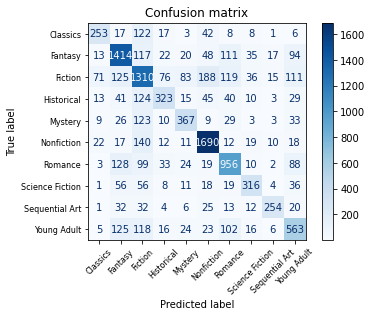

<Figure size 1080x1080 with 0 Axes>

In [34]:
plot_cm(svm_pipeline, X_test, y_test)

In [35]:
svm_pipeline = Pipeline([
    ('sel', SelectKBest(chi2, k=5000)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC(C = 0.1))  # learning algorithm
])

svm_pipeline.fit(X_train_tok,y_train)
predictions = svm_pipeline.predict(X_test_tok)


In [36]:

print('Classification report:')
print(classification_report(predictions, y_test))
print('Confusion matrix:')
cm = confusion_matrix(predictions, y_test)
print(cm)

Classification report:
                 precision    recall  f1-score   support

       Classics       0.35      0.71      0.47       232
        Fantasy       0.79      0.66      0.72      2268
        Fiction       0.62      0.55      0.58      2409
     Historical       0.38      0.68      0.49       359
        Mystery       0.56      0.66      0.60       519
     Nonfiction       0.87      0.72      0.79      2365
        Romance       0.71      0.65      0.68      1504
Science Fiction       0.46      0.76      0.57       316
 Sequential Art       0.46      0.87      0.60       212
    Young Adult       0.48      0.59      0.53       808

       accuracy                           0.65     10992
      macro avg       0.57      0.68      0.60     10992
   weighted avg       0.69      0.65      0.66     10992

Confusion matrix:
[[ 165    6   33    8    2   13    2    1    0    2]
 [  36 1487  137   78   34   22  140   91   70  173]
 [ 164  113 1321  167  138  162   93   79   40  132]

<Figure size 1080x1080 with 0 Axes>

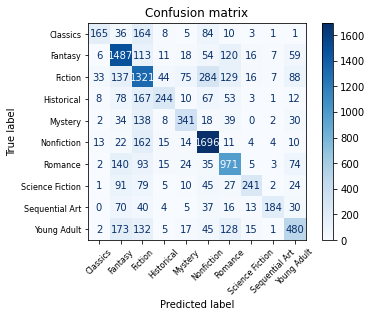

<Figure size 1080x1080 with 0 Axes>

In [37]:
plot_cm(svm_pipeline, X_test_tok, y_test)

### Grid Search

In [38]:
param_grid = [{'sel__k': [3000, 5000, 7000,'all'], 'learner__C': [0.01, 0.1, 1, 10, 100]}]

opt_pipeline = Pipeline([
    ('sel', SelectKBest(chi2)),  
    ('tfidf', TfidfTransformer()), 
    ('learner', LinearSVC())
])

n_jobs = 5 
SVM_opt_search = GridSearchCV(opt_pipeline, param_grid, cv=10, n_jobs = n_jobs, verbose=True).fit(X_train_tok, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   16.3s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  4.8min
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:  6.2min finished


In [39]:
SVM_opt_search.best_params_


{'learner__C': 0.1, 'sel__k': 5000}

In [40]:
SVM_opt_search.best_estimator_


Pipeline(steps=[('sel',
                 SelectKBest(k=5000,
                             score_func=<function chi2 at 0x00000231855D30D0>)),
                ('tfidf', TfidfTransformer()), ('learner', LinearSVC(C=0.1))])

In [41]:
len(opt_predictions)

NameError: name 'opt_predictions' is not defined

In [ ]:
opt_predictions = SVM_opt_search.best_estimator_.predict(X_test_tok)

print('Classification report:')
print(classification_report(y_test, opt_predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, opt_predictions)
print(cm)

In [ ]:
eval_accuracy(y_test, opt_predictions)

In [ ]:
tokenizer = vect
selector = svm_pipeline.named_steps['sel']
classifier = svm_pipeline.named_steps['learner']

In [ ]:
feature_names = tokenizer.get_feature_names()
feats_w_score = list()
for index,(selected,score) in enumerate(zip(selector.get_support(),selector.scores_)):
    feats_w_score.append((score,selected,feature_names[index]))
feats_w_score = sorted(feats_w_score)
len(feats_w_score)

In [ ]:
feats_w_score[:100]

In [ ]:
feats_w_score[-100:]


In [ ]:
feats_w_classifier_weight = list()
for index,weight in enumerate(selector.inverse_transform(classifier.coef_)[0]):
    if weight!=0:
        feats_w_classifier_weight.append((weight,feature_names[index]))
feats_w_classifier_weight = sorted(feats_w_classifier_weight)
len(feats_w_classifier_weight)

In [ ]:
feats_w_classifier_weight[-100:]


In [ ]:
feats_w_classifier_weight[100:]


### SVM binary

In [114]:
df_binary

,book_authors,book_desc,book_rating,book_title,genres
11,Dan Brown,An ingenious code hidden in the works of Leona...,3.81,The Da Vinci Code,Fiction
12,Arthur Golden,"A literary sensation and runaway bestseller, t...",4.09,Memoirs of a Geisha,Fiction
14,Oscar Wilde|Jeffrey Eugenides,"﻿Written in his distinctively dazzling manner,...",4.06,The Picture of Dorian Gray,Fiction
20,Paulo Coelho|Alan R. Clarke|Özdemir İnce,Paulo Coelho's masterpiece tells the mystical ...,3.84,The Alchemist,Fiction
25,Kathryn Stockett,Be prepared to meet three unforgettable women:...,4.46,The Help,Fiction
...,...,...,...,...,...
36633,Siri Hustvedt,"A brilliant, provocative novel about an artist...",3.67,The Blazing World,Fiction
36634,Avi Steinberg,Avi Steinberg is stumped. After defecting from...,3.51,Running the Books: The Adventures of an Accide...,Nonfiction
36635,Howard Megdal,"In this fearless and half-crazy story, Howard ...",3.37,Taking the Field: A Fan's Quest to Run the Tea...,Nonfiction
36636,Howard Megdal,From the icons of the game to the players who ...,3.97,"The Baseball Talmud: Koufax, Greenberg, and th...",Nonfiction


In [115]:
X_binary = df_binary["book_desc"]
y_binary = df_binary["genres"]


X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(X_binary, y_binary,  test_size=0.30, random_state=1)

In [116]:
print('fit')
# Just creating the features space. It define the dimensions.
vect.fit(X_train_binary) 
print('transform')
#Creating the vectors
X_train_tok_binary = vect.transform(X_train_binary)
print('done')
X_test_tok_binary = vect.transform(X_test_binary)

fit
transform
done


In [117]:
svm_pipeline = Pipeline([
    ('vect', TfidfVectorizer(min_df = 5)), #tokenization
    ('sel', SelectKBest(chi2, k=7000)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm
])

svm_pipeline.fit(X_train_binary, y_train_binary)
predictions_test_binary = svm_pipeline.predict(X_test_binary)
predictions_train_binary = svm_pipeline.predict(X_train_binary)

In [118]:
print('Classification report:')
print(classification_report(y_train_binary, predictions_train_binary))
print('Confusion matrix:')
cm = confusion_matrix(y_train_binary, predictions_train_binary)
print(cm)

Classification report:
              precision    recall  f1-score   support

     Fiction       1.00      1.00      1.00      4990
  Nonfiction       0.99      1.00      1.00      4542

    accuracy                           1.00      9532
   macro avg       1.00      1.00      1.00      9532
weighted avg       1.00      1.00      1.00      9532

Confusion matrix:
[[4966   24]
 [  19 4523]]


In [119]:
predictions_test_binary = svm_pipeline.predict(X_test_binary)
print('Classification report:')
print(classification_report(y_test_binary, predictions_test_binary))
print('Confusion matrix:')
cm = confusion_matrix(y_test_binary, predictions_test_binary)
print(cm)

Classification report:
              precision    recall  f1-score   support

     Fiction       0.88      0.91      0.89      2124
  Nonfiction       0.90      0.87      0.88      1962

    accuracy                           0.89      4086
   macro avg       0.89      0.89      0.89      4086
weighted avg       0.89      0.89      0.89      4086

Confusion matrix:
[[1924  200]
 [ 253 1709]]


<Figure size 1080x1080 with 0 Axes>

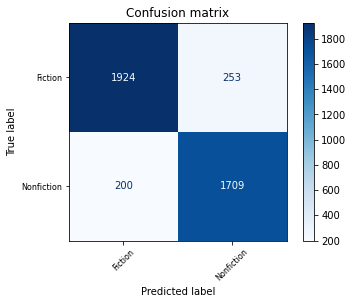

In [128]:
plot = plot_cm(svm_pipeline, y_test_binary, predictions_test_binary)
